# Movie Recommendation System (Using User Based Collaborative Filtering)

In [1]:
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
movies=pd.read_csv('C:\\Users\\radhika\\Desktop\\kaggle\\ml-latest-small\\movies.csv')
ratings=pd.read_csv('C:\\Users\\radhika\\Desktop\\kaggle\\ml-latest-small\\ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies=movies.drop('genres',1)

In [5]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [8]:
#Removing year from the name of movies
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())


In [9]:
movies.head()

,movieId,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


In [10]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [11]:
#dropping timestamp column
ratings=ratings.drop('timestamp',1)

In [12]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [20]:
userInput=[]
print('******Hey there!******')
print('Let\'s create your profile, Enter the movies:-)')
s='yes'
while(s=='yes' or s=='Yes' or s=='YES'):
    temp={}
    mov=input('Title:')
    rati=float(input('Ratings:'))
    temp['title']=mov
    temp['ratings']=rati
    userInput.append(temp)
    s=input('Want to add more movies?')
else:
    print('Okay, Thanks')

******Hey there!******
Let's create your profile, Enter the movies:-)
Title:Breakfast Club, The
Ratings:5
Want to add more movies?yes
Title:Toy Story
Ratings:3.5
Want to add more movies?yes
Title:Jumanji
Ratings:2
Want to add more movies?yes
Title:Pulp Fiction
Ratings:5
Want to add more movies?yes
Title:Akira
Ratings:4.5
Want to add more movies?No


Here we have taken the list of movies along with their ratings from the user and now we will recommend movies to this user by finding the users that have similar preferences and opinion and recommend items that they have liked to the input user.

In [21]:
inputMovies=pd.DataFrame(userInput)

In [22]:
inputMovies

,title,ratings
0,"Breakfast Club, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


Now we have to find out the movieId of the input movies from our database

In [23]:
#filtering out the movies by title
inputId=movies[movies['title'].isin(inputMovies['title'].tolist())]

In [25]:
#Now merging it by title
inputMovies=pd.merge(inputId,inputMovies)

In [26]:
inputMovies

,movieId,title,year,ratings
0,1,Toy Story,1995,3.5
1,2,Jumanji,1995,2.0
2,296,Pulp Fiction,1994,5.0
3,1274,Akira,1988,4.5
4,1968,"Breakfast Club, The",1985,5.0


Here we can see that we won't need year column in future so we will drop it.

In [27]:
inputMovies=inputMovies.drop('year',1)

Now here we have final input dataframe

In [28]:
inputMovies

,movieId,title,ratings
0,1,Toy Story,3.5
1,2,Jumanji,2.0
2,296,Pulp Fiction,5.0
3,1274,Akira,4.5
4,1968,"Breakfast Club, The",5.0


Now as we have Movie Id's we can find the users who have watched and reviewed these movies.

In [30]:
NeighborUsers=ratings[ratings['movieId'].isin(inputMovies['movieId'].tolist())]

In [33]:
NeighborUsers.head()

,userId,movieId,rating
0,1,1,4.0
16,1,296,3.0
320,4,296,1.0
422,4,1968,4.0
516,5,1,4.0


Now we will group the rows by userId.

In [50]:
NeighborUsersGroup=NeighborUsers.groupby(['userId'])

In [40]:
#let's check for any user
NeighborUsersGroup.get_group(5)

,userId,movieId,rating
516,5,1,4.0
533,5,296,5.0


Now we have to sort these groups also sothat the users that share the most of the movies in common with our input user have the highest priority.

In [72]:
NeighborUsersGroup=sorted(NeighborUsersGroup,key=lambda x: len(x[1]),reverse=True)

Now we will check the Similarity of users with our input user.

For that purpose we are using Pearson Correlation Coefficient here. It measures the strength of a linear association between two variables, where the value r = 1 means a perfect positive correlation and the value r = -1 means a perfect negataive correlation. So, for example, you could use this test to find out whether people's height and weight are correlated (they will be - the taller people are, the heavier they're likely to be).

Requirements for Pearson's correlation coefficient

->Scale of measurement should be interval or ratio
->Variables should be approximately normally distributed
->The association should be linear
->There should be no outliers in the data 

Here we are using Pearson correlation beacause it is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. This is a pretty important property in recommendation systems because for example two users might rate two series of items totally different in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales .

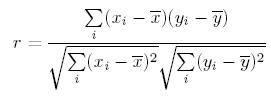

In our case, r=1 means that the two users have similar tastes while r=-1 means the opposite.

Now we will select top users from our Neighbor users as we want the best result and we don't want to waste our time going through every single user.

In [73]:
NeighborUsersGroup=NeighborUsersGroup[0:100]

Now we will calculate Pearson Coefficient between input user and Neighbor users. We will store them in a dictionary where key is User ID and the value is Coefficient.

In [53]:
Pearson={}

In [67]:
for name,group in NeighborUsersGroup:
    group=group.sort_values(by='movieId')
    inputMovies=inputMovies.sort_values(by='movieId')
    #findout the number of ratings to be used in Pearson coefficient formula
    nRati=len(group)
    
    #Find the ratings(of input user) of the movies that input user and it's neighbor have in common
    temp=inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    tempList=temp['ratings'].tolist()
    
    #current user
    tempgList=group['rating'].tolist()
    
    #calculating Pearson Correlation Coefficient x be for input user and y be for neighbor user
    xbar=sum([i for i in tempList])/float(nRati)
    ybar=sum([j for j in tempgList])/float(nRati)
    Sxx=sum([(i-xbar)**2 for i in tempList])
    Syy=sum([(j-ybar)**2 for j in tempgList])
    Sxy=sum([(tempList[i]-xbar)*(tempgList[j]-ybar) for i in range(nRati) for j in range(nRati) if i==j])
    
    if Sxx!=0 and Syy!=0:
        Pearson[name]=Sxy/sqrt(Sxx*Syy)
    else:
        Pearson[name]=0

In [64]:
Pearson

{1: -1.0,
 4: 0,
 5: 1.0,
 6: -1.0,
 7: 0,
 8: 0,
 10: 0,
 14: 0,
 15: 1.0,
 16: 0,
 17: 1.0,
 18: 1.0,
 19: -0.5,
 20: 0,
 21: 0,
 23: -1.0,
 24: 0,
 26: 0,
 27: -1.0,
 28: 0,
 29: 0,
 31: 0,
 32: 1.0,
 33: 1.0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: -1.0,
 44: 0,
 45: 0.5,
 46: 0,
 47: 0,
 50: 0.15713484026367722,
 51: 0,
 54: 0,
 56: 0,
 57: -0.7385489458759964,
 58: 0,
 62: 1.0,
 63: -0.5,
 64: 0.0,
 66: 0.5,
 67: 0,
 68: 0.0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 76: 1.0,
 78: 0,
 81: 0,
 82: -1.0,
 84: 0,
 86: 0,
 89: 0,
 90: 0,
 91: 0.4385290096535145,
 93: -1.0,
 94: 0,
 95: -1.0,
 96: 0,
 98: 0,
 99: 0,
 100: 0,
 102: 0,
 103: 0.5222329678670935,
 104: 0,
 105: 1.0,
 107: -1.0,
 108: 0,
 109: 0,
 110: 0,
 112: 1.0,
 115: 0,
 117: 1.0,
 118: 0,
 119: 1.0,
 121: 0,
 122: 0.8660254037844387,
 123: 0,
 124: 1.0,
 125: 1.0,
 126: 0,
 129: 0,
 130: 1.0,
 131: 0,
 132: 1.0,
 133: 0,
 134: 1.0,
 135: 0.8703882797784892,
 136: 0,
 137: -1.0,
 140: 0.5,
 141: 0,

Now here we have the Pearson Coefficient of all the users.

In [76]:
pearsonData=pd.DataFrame.from_dict(Pearson,orient='index')
pearsonData.columns=['Pearson Similarity Index']
pearsonData['userID']=pearsonData.index
pearsonData.index=range(len(pearsonData))

In [77]:
pearsonData.head()

,Pearson Similarity Index,userID
0,-1.0,1
1,0.0,4
2,1.0,5
3,-1.0,6
4,0.0,7


Now we will find 50 users that are most similar to input user

In [79]:
topUsers=pearsonData.sort_values(by='Pearson Similarity Index', ascending=False)[0:50]

In [87]:
topUsers.index=range(1,51)

In [88]:
topUsers

,Pearson Similarity Index,userID
1,1.0,233
2,1.0,489
3,1.0,130
4,1.0,105
5,1.0,169
6,1.0,580
7,1.0,125
8,1.0,124
9,1.0,260
10,1.0,62


Now we are done with finding similar users according to our input user and now we have to recommend movies to our input user.

First of all we need the movies watched by these top 50 users in this dataframe from ratings dataframe and then store their correlation in a new column Similarity index.

In [92]:
topUsersRating=topUsers.merge(ratings,left_on='userID', right_on='userId',how='inner')

In [93]:
topUsersRating

,Pearson Similarity Index,userID,userId,movieId,rating
0,1.0,233,233,1,3.0
1,1.0,233,233,47,3.5
2,1.0,233,233,50,4.0
3,1.0,233,233,110,3.0
4,1.0,233,233,150,2.0
...,...,...,...,...,...
10235,1.0,517,517,160980,2.5
10236,1.0,517,517,162590,1.0
10237,1.0,517,517,164909,1.0
10238,1.0,517,517,165489,2.5


Now all we need to do is simply multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

It shows the idea of all similar users to candidate movies for the input user:

In [96]:
topUsersRating['weightedRating']=topUsersRating['Pearson Similarity Index']*topUsersRating['rating']
topUsersRating.head(10)

,Pearson Similarity Index,userID,userId,movieId,rating,weightedRating
0,1.0,233,233,1,3.0,3.0
1,1.0,233,233,47,3.5,3.5
2,1.0,233,233,50,4.0,4.0
3,1.0,233,233,110,3.0,3.0
4,1.0,233,233,150,2.0,2.0
5,1.0,233,233,296,4.0,4.0
6,1.0,233,233,318,5.0,5.0
7,1.0,233,233,356,5.0,5.0
8,1.0,233,233,364,3.5,3.5
9,1.0,233,233,367,3.5,3.5


In [98]:
#Summing the new ratings after grouping it by user Id
tempTopRating=topUsersRating.groupby('movieId').sum()[['Pearson Similarity Index','weightedRating']]
tempTopRating.columns=['sum_similarity_index','sum_weightedRating']
tempTopRating.head(10)

,sum_similarity_index,sum_weightedRating
movieId,,
1,35.0,123.0
2,18.0,57.5
3,3.0,11.0
5,4.0,10.5
6,12.0,45.5
7,6.0,18.5
10,14.0,45.5
11,10.0,34.5
14,1.0,5.0


In [118]:
recommend=pd.DataFrame()
recommend['weighted average recommendation score']=tempTopRating['sum_weightedRating']/tempTopRating['sum_similarity_index']
recommend['movieId']=tempTopRating.index
recommend.head(10)

,weighted average recommendation score,movieId
movieId,,
1,3.514286,1
2,3.194444,2
3,3.666667,3
5,2.625000,5
6,3.791667,6
7,3.083333,7
10,3.250000,10
11,3.450000,11
14,5.000000,14


Now we are ready to go! Let's sort and  see top 10 movies that our system has recommended.

In [119]:
recommend=recommend.sort_values(by='weighted average recommendation score',ascending=False)
recommend.head(10)

,weighted average recommendation score,movieId
movieId,,
1939,5.0,1939
105197,5.0,105197
1518,5.0,1518
105585,5.0,105585
151769,5.0,151769
105593,5.0,105593
1464,5.0,1464
4788,5.0,4788
9018,5.0,9018


In [145]:
final=movies.loc[movies['movieId'].isin(recommend.head(10)['movieId'].tolist())]
final.index=range(1,11)

Here we go! 

In [146]:
final

,movieId,title,year
1,1464,Lost Highway,1997
2,1518,Breakdown,1997
3,1939,"Best Years of Our Lives, The",1946
4,4788,Moscow Does Not Believe in Tears (Moskva sleza...,1979
5,4912,Funny Girl,1968
6,9018,Control Room,2004
7,105197,Nebraska,2013
8,105585,Machete Kills (Machete 2),2013
9,105593,Filth,2013
10,151769,Three from Prostokvashino,1978


These are top 10 movies that are recommended by our recommendation system too our input user.